In [ ]:
!pip install torchaudio
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Data Handling

In [ ]:
import random
def extractData(n_speakers, n_samples):
    speaker_data_dict = {}
    speaker_data_list = []

    dataset = torchaudio.datasets.LIBRISPEECH(root='/content/drive/My Drive/',download=False)

    for data in dataset:
        current_n_speakers = len(speaker_data_dict.keys())
        if data[3] not in speaker_data_dict.keys():
            if current_n_speakers == n_speakers: break
            current_n_speakers += 1            
            n_s = data[0].shape[1] // 32000
            all_samples = data[0][0,:n_s*32000].view(n_s, 32000)
            speaker_data_dict[data[3]] = all_samples

        else :
            n_s = data[0].shape[1] // 32000
            all_samples = data[0][0,:n_s*32000].view(n_s, 32000)
            speaker_data_dict[data[3]] = torch.cat([speaker_data_dict[data[3]], all_samples], 0)

    for id in speaker_data_dict.keys():
        random.shuffle(speaker_data_dict[id])
        if speaker_data_dict[id].size(0) < n_samples: continue
        spec = torchaudio.transforms.MelSpectrogram(hop_length=251)(speaker_data_dict[id][:n_samples])
        spec = torchaudio.transforms.AmplitudeToDB()(spec).view(n_samples, 1, 128, 128)
        speaker_data_list.append(spec)  
    
    return speaker_data_list

In [ ]:
class SpeakerDataset(Dataset):
    def __init__(self, data, n_speakers):
        super(SpeakerDataset, self).__init__()
        self.n_speakers = n_speakers
        self.data = data

    def __getitem__(self, speaker_id):
        return self.data[speaker_id.item()]

    def __len__(self):
        return self.n_speakers        

In [ ]:
class EpisodicBatchSampler(object):
    def __init__(self, n_speakers, n_way, n_episodes):
        self.n_speakers = n_speakers
        self.n_way = n_way
        self.n_episodes = n_episodes

    def __len__(self):
        return self.n_episodes

    def  __iter__(self):
        for episode in range(self.n_episodes):
            #print(self.n_speakers)
            speakers = torch.randperm(self.n_speakers)[:self.n_way]
            #print(torch.randperm(self.n_speakers)[:self.n_way])
            yield torch.randperm(self.n_speakers)[:self.n_way]

In [ ]:
def extractEpisode(data, n_support, n_query):
    xs, xq = [], []
    for d in data:
        xs.append(d[:n_support])
        xq.append(d[n_support:n_support+n_query])

    return {
        'xs' : torch.stack(xs), 
        'xq' : torch.stack(xq)
    }

In [ ]:
n_speakers = 20
speakerData = extractData(n_speakers, 300)
traindata_dict, testdata_dict = {}, {}
for sid in range(n_speakers):
    if sid < 15: traindata_dict[sid] = speakerData[sid]
    else: testdata_dict[sid % 15] = speakerData[sid]

In [ ]:
traindata = SpeakerDataset(traindata_dict, 15)
testdata = SpeakerDataset(testdata_dict, 5)

In [ ]:
testdata[torch.tensor(4)].shape

torch.Size([300, 1, 128, 128])

In [ ]:
n_way = 5
n_episodes = 100
sampler1 = EpisodicBatchSampler(len(traindata), n_way, n_episodes)
sampler2 = EpisodicBatchSampler(len(testdata), 5, 1)
trainloader = DataLoader(traindata, batch_sampler=sampler1, num_workers=0)
testloader = DataLoader(testdata, batch_sampler=sampler2, num_workers=0)

Neural Network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ProtoNet(nn.Module):
    def __init__(self):
        super(ProtoNet, self).__init__()

        self.encoder = nn.Sequential(
            conv_block(1, 3, 5),
            conv_block(3, 6, 3),
            conv_block(6, 6, 3),
            conv_block(6, 6, 3),
            Flatten(),
            nn.Linear(216, 128),
            nn.ReLU()
        )

    def forward(self, x):
        return self.encoder(x)


class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)


def conv_block(n_inputc, n_outputc, n_kernel):
    return nn.Sequential(
        nn.Conv2d(n_inputc, n_outputc, n_kernel),
        nn.BatchNorm2d(n_outputc),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

protonet = ProtoNet()        

In [ ]:
def euclidean_dist(x, y):
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

def prototype_loss(encodings, n_speaker, n_support, n_query):
    encoding_dim = encodings.size(-1)
    prototypes = encodings[:n_speaker*n_support].view(n_speaker, n_support, encoding_dim).mean(1)
    queries = encodings[n_speaker*n_support:]
    
    speaker_ind = torch.arange(0, n_speaker, requires_grad = False).view(n_speaker, 1, 1).expand(n_speaker, n_query, 1).long()

    dists = euclidean_dist(queries, prototypes)

    logp = F.log_softmax(-dists, dim=1).view(n_speaker, n_query, -1)

    loss = -logp.gather(2, speaker_ind).squeeze().view(-1).mean()

    return loss, logp

In [ ]:
optimizer = torch.optim.SGD(protonet.parameters(), lr = .01)

In [ ]:
acc = []
for data in trainloader:
    episode = extractEpisode(data, 5, 200)
    xs = episode['xs']
    xq = episode['xq']

    n_speaker = xs.size(0)
    n_support = xs.size(1)
    n_query = xq.size(1)

    x = torch.cat((xs.view(n_speaker * n_support, *xs.size()[2:]),
                xq.view(n_speaker * n_query, *xq.size()[2:])), dim=0)
    
    optimizer.zero_grad()
    z = protonet(x)
    
    loss, log_prob = prototype_loss(z, n_speaker, n_support, n_query)
    loss.backward()
    optimizer.step()
    _, y_hat = log_prob.max(2)
    speaker_ind = torch.arange(0, n_speaker, requires_grad = False).view(n_speaker, 1).expand(n_speaker, n_query).long()
    acc.append(torch.eq(y_hat, speaker_ind).float().mean())

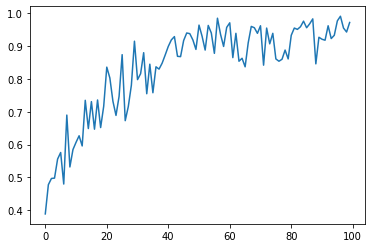

In [ ]:
plt.plot(acc)

In [ ]:
def test_protonet(testloader, n_query):
    for data in testloader:
        episode = extractEpisode(data, 5, n_query)
        xs = episode['xs']
        xq = episode['xq']
        print(xq.shape)
        n_speaker = xs.size(0)
        n_support = xs.size(1)
        n_query = xq.size(1)

        x = torch.cat((xs.view(n_speaker * n_support, *xs.size()[2:]),
                xq.view(n_speaker * n_query, *xq.size()[2:])), dim=0)
        
        z = protonet(x)

        loss, log_prob = prototype_loss(z, n_speaker, n_support, n_query)
        _, y_hat = log_prob.max(2)
        speaker_ind = torch.arange(0, n_speaker, requires_grad = False).view(n_speaker, 1).expand(n_speaker, n_query).long()
        return torch.eq(y_hat, speaker_ind).float().mean()

In [ ]:
acc = []
for n in range(105, 205):
    acc.append(test_protonet(testloader, n))

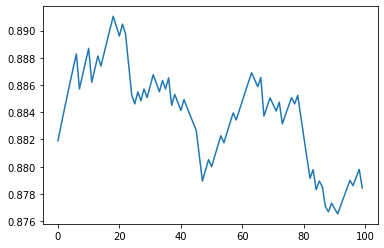

In [ ]:
plt.plot(acc)

In [ ]:
test_protonet(testloader, 401)

torch.Size([5, 295, 1, 128, 128])


tensor(0.8814)

In [ ]:
test